# Raster Mosaicing and Clipping

## Introduction

The [`rioxarray`](https://corteva.github.io/rioxarray/stable/) extension adds support for working with raster data using XArray. In this tutorial, we explore basic raster processing of reading, mosaicing and clipping raster data using XArray.

## Overview of the Task

We will work with elevation data for Sri Lanka in the form of individual SRTM tiles, merge them and clip the resulting mosaic to the country boundary. We will also save the resulting raster as a Cloud-optimized GeoTIFF (COG).


**Input Layers**:
* `[NXXEYYY].SRTMGL1.hgt.zip`: Zipped raster tiles in SRTM HGT format
* `ne_10m_admin_0_countries.zip`: A shapefile of country boundaries

**Output**:
* `clipped.tif`: A clipped and mosaiced GeoTiff file for Sri Lanka.

**Data Credit**:
- NASA Shuttle Radar Topography Mission Global 1 arc second provided by The Land Processes Distributed Active Archive Center (LP DAAC). Downloaded using the [30-Meter SRTM Tile Downloader](https://dwtkns.com/srtm30m/).
- Made with Natural Earth. Free vector and raster map data @ naturalearthdata.com.


**Watch Video Walkthrough** <a href='https://www.youtube.com/watch?v=Ff9ctKNlku0' target='_blank'><img src='https://github.com/spatialthoughts/geopython-tutorials/blob/main/images/yt_logo.png?raw=1'></a>

## Setup and Data Download

The following blocks of code will install the required packages and download the datasets to your Colab environment.

In [ ]:
%%capture
if 'google.colab' in str(get_ipython()):
    !pip install rioxarray

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import os
import rioxarray as rxr
from rioxarray.merge import merge_arrays
import shapely
import xarray as xr

In [ ]:
data_folder = 'data'
output_folder = 'output'

if not os.path.exists(data_folder):
    os.mkdir(data_folder)
if not os.path.exists(output_folder):
    os.mkdir(output_folder)

In [ ]:
def download(url):
    filename = os.path.join(data_folder, os.path.basename(url))
    if not os.path.exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

srtm_tiles = [
  'N05E080.SRTMGL1.hgt.zip',
  'N06E079.SRTMGL1.hgt.zip',
  'N06E080.SRTMGL1.hgt.zip',
  'N06E081.SRTMGL1.hgt.zip',
  'N07E079.SRTMGL1.hgt.zip',
  'N07E080.SRTMGL1.hgt.zip',
  'N07E081.SRTMGL1.hgt.zip',
  'N08E079.SRTMGL1.hgt.zip',
  'N08E080.SRTMGL1.hgt.zip',
  'N08E081.SRTMGL1.hgt.zip',
  'N09E080.SRTMGL1.hgt.zip',
  'N09E079.SRTMGL1.hgt.zip'
]

shapefile = 'ne_10m_admin_0_countries_ind.zip'

data_url = 'https://github.com/spatialthoughts/geopython-tutorials/releases/download/data/'

for tile in srtm_tiles:
  url = '{}/{}'.format(data_url, tile)
  download(url)

download('{}/{}'.format(data_url,shapefile))

## Procedure

For this tutorial, we want to mosaic the source tiles and clip them to the boundary of Sri Lanka. We read the Natural Earth administrative regions shapefile.

In [ ]:
shapefile_path = os.path.join(data_folder, shapefile)
boundaries_gdf = gpd.read_file(shapefile_path)

We filter the dataframe using the ADM0_A3 column and extract the geometry.

In [ ]:
filtered_gdf = boundaries_gdf[boundaries_gdf['ADM0_A3'] == 'LKA']
geometry = filtered_gdf.geometry
geometry

Next, we read the zipped SRTM tiles using rioxarray. rioxarray uses GDAL to read raster datasets, and can read zipped SRTM files directly. We also specify `mask_and_scale=False` so the nodata values from the input rasters is preserved and not set to NaN.

In [ ]:
datasets = []
for tile in srtm_tiles:
  zipfile = os.path.join(data_folder, tile)
  ds = rxr.open_rasterio(zipfile, mask_and_scale=False)
  datasets.append(ds)

We can get the bounding box of each image and create a GeoDataFrame to visualize the extent of the coverage along with the chosen region.

In [ ]:
bboxes = []
for ds in datasets:
    bounds = ds.rio.bounds()
    bbox = shapely.box(*bounds)  # Create a shapely box object
    bboxes.append(bbox)

gdf = gpd.GeoDataFrame(geometry=bboxes, crs=datasets[0].rio.crs)

Plot the bounding boxes and the chosen admin boundary.

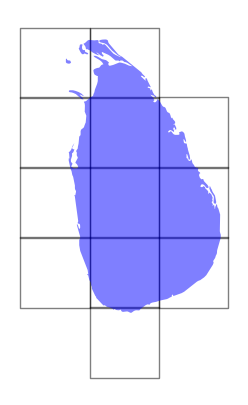

In [ ]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(5,5)
gdf.plot(
    ax=ax,
    facecolor='none',
    edgecolor='black',
    alpha=0.5)

filtered_gdf.plot(
    ax=ax,
    facecolor='blue',
    alpha=0.5
)
ax.set_axis_off()
plt.show()


Now that we have a list of XArray datasets, we can use the `merge_arrays` function from `rioxarray` to merge them into a mosaic.

In [ ]:
merged = merge_arrays(datasets)
merged

Now we clip the merged raster using the `clip` function from `rioxarray`. For XArray datasets, we can use the `rio` accessor to run the `rioxarray` functions.

In [ ]:
clipped = merged.rio.clip(filtered_gdf.geometry)

Last step is to save the results to disk as GeoTiff files. We use [Cloud-Optimized GeoTIFF (COG)](https://gdal.org/drivers/raster/cog.html) driver and specify additional GDAL [compression options](https://rasterio.readthedocs.io/en/stable/topics/image_options.html#creation-options).

In [ ]:
output_dem = 'clipped.tif'
output_dem_path = os.path.join(output_folder, output_dem)
clipped.rio.to_raster(
    output_dem_path, driver='COG', dtype='int16',
    compress='DEFLATE', predictor='YES')

----

If you want to give feedback or share your experience with this tutorial, please comment below. (requires GitHub account)


<script src='https://utteranc.es/client.js'
    repo='spatialthoughts/geopython-tutorials'
    issue-term='pathname'
    theme='github-light'
    crossorigin='anonymous'
    async>
</script>